In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *

import numpy as np

# Imports PIL module 
from PIL import Image
import matplotlib.pyplot as plt 

import os

from sklearn.model_selection import train_test_split

In [2]:
raw_dir = "./train_test_data/class_raw/"
other_dir = "./train_test_data/class_other/"
cool_dir = "./train_test_data/class_cool/"
babka_dir = "./train_test_data/class_babka/"

image_size = 224
batch_size = 16

In [3]:
def predict(model, image_path):
    
    im = Image.open(image_path)
    im = im.resize((image_size, image_size), resample = Image.Resampling.BILINEAR)

    data = np.array(im) / 255.

    return model.predict(np.expand_dims(data, axis = 0))

In [4]:
pretrained_base = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=[image_size, image_size, 3])
pretrained_base.trainable = False

In [6]:
raw_images = [raw_dir + i for i in os.listdir(raw_dir)]
other_images = [other_dir + i for i in os.listdir(other_dir)]
cool_images = [cool_dir + i for i in os.listdir(cool_dir)]
babka_images = [babka_dir + i for i in os.listdir(babka_dir)]

raw_images[:3], other_images[:3], cool_images[:3], babka_images[:3]

(['./train_test_data/class_raw/10.jpg',
  './train_test_data/class_raw/1005.jpg',
  './train_test_data/class_raw/1006.jpg'],
 ['./train_test_data/class_other/1000.jpg',
  './train_test_data/class_other/1001.jpg',
  './train_test_data/class_other/1002.jpg'],
 ['./train_test_data/class_cool/1.jpg',
  './train_test_data/class_cool/10.jpg',
  './train_test_data/class_cool/1004.jpg'],
 ['./train_test_data/class_babka/1.jpg',
  './train_test_data/class_babka/10.jpg',
  './train_test_data/class_babka/100.jpg'])

In [7]:
len(raw_images), len(other_images), len(cool_images), len(babka_images)

(429, 551, 677, 925)

In [8]:
# готовим данные изображений для добавления изображений в модель

data = []
c = 0

for class_ in (raw_images, other_images, cool_images, babka_images):

    if c == 0:
        y = [c] * len(class_)
    else:
        y.extend([c] * len(class_))

    c += 1

    for image in class_:
        im = Image.open(image)
        im = im.resize((image_size, image_size), resample = Image.Resampling.BILINEAR)
        data.append(im)

data = np.array([np.array(i) for i in data])

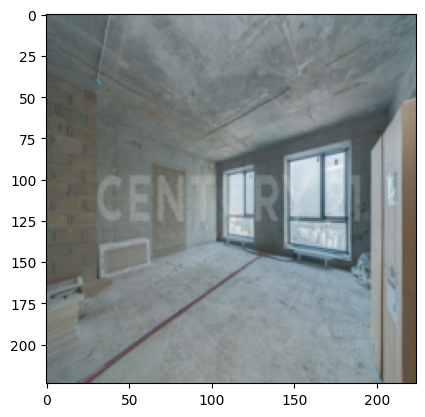

In [9]:
for i in data:
    plt.imshow(i.astype("uint8"))
    break

In [10]:
data = data / 255.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=123)

In [13]:
y_train_cat = tf.keras.utils.to_categorical(y_train, 4)
y_test_cat = tf.keras.utils.to_categorical(y_test, 4)

In [14]:
X_train.shape

(2065, 224, 224, 3)

In [15]:
model = tf.keras.Sequential([

    pretrained_base,

    Flatten(),
    Dense(128, activation='relu'),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax'),
])


In [16]:
print(model.summary())      # вывод структуры НС в консоль

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 71,178,964
Trainable params: 12,847,316
Non-trainable params: 58,331,648
_________________________________________________________________
None


In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=10,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True, name="SGD")

model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [18]:
history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), batch_size=batch_size, epochs=25, callbacks=[callback],)

model.evaluate(X_test, y_test_cat)

Epoch 1/25
130/130 [==============================] - 27s 130ms/step - loss: 0.7797 - categorical_accuracy: 0.7380 - val_loss: 0.5680 - val_categorical_accuracy: 0.7795
Epoch 2/25
130/130 [==============================] - 14s 105ms/step - loss: 0.2367 - categorical_accuracy: 0.9225 - val_loss: 0.3729 - val_categorical_accuracy: 0.8723
Epoch 3/25
130/130 [==============================] - 13s 102ms/step - loss: 0.0765 - categorical_accuracy: 0.9748 - val_loss: 0.3930 - val_categorical_accuracy: 0.8878
Epoch 4/25
130/130 [==============================] - 14s 105ms/step - loss: 0.0377 - categorical_accuracy: 0.9903 - val_loss: 0.3708 - val_categorical_accuracy: 0.8956
Epoch 5/25
130/130 [==============================] - 14s 106ms/step - loss: 0.0258 - categorical_accuracy: 0.9893 - val_loss: 0.4380 - val_categorical_accuracy: 0.8839
Epoch 6/25
130/130 [==============================] - 14s 104ms/step - loss: 0.0190 - categorical_accuracy: 0.9927 - val_loss: 0.4169 - val_categorical_acc

[0.3728635013103485, 0.8723404407501221]

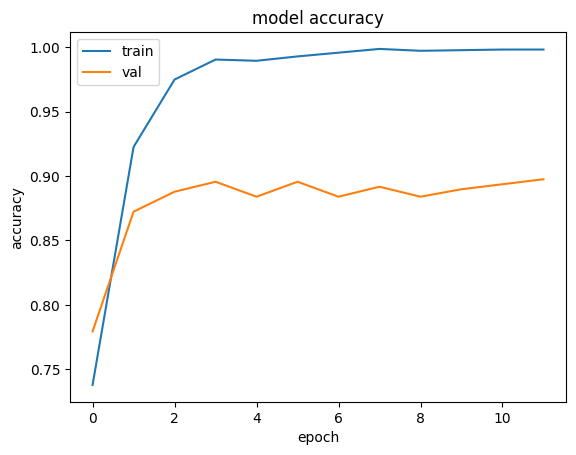

In [19]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
model.save('./saved_models/model_v2')

INFO:tensorflow:Assets written to: ./saved_models/model_v2\assets


INFO:tensorflow:Assets written to: ./saved_models/model_v2\assets


In [30]:
predict(model, r"E:\kvartira-moskva-volokolamskoe-shosse-1416206141-4.jpg")

1/1 [==============================] - 0s 67ms/step


array([[3.1610052e-04, 9.8489434e-04, 9.9404860e-01, 4.6504308e-03]],
      dtype=float32)

In [ ]:
# если есть хоть одна raw убираем
# чтобы не менее 3 фоток были cool